In [49]:
from io import BytesIO

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [67]:
torch.set_default_device("cuda")

In [68]:
class MnistDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_parquet(file_path)
        self.length = len(df)

        self.images = torch.zeros(
            (self.length, 28 * 28), dtype=torch.float32, device="cuda"
        )
        self.labels = torch.zeros(self.length, dtype=torch.long, device="cuda")

        for i, entry in df.iterrows():
            with Image.open(BytesIO(entry["image.bytes"])) as img:
                img_gray = img.convert("L")
                self.images[i, :] = torch.tensor(
                    np.array(img_gray).flatten() / 255.0, dtype=torch.float32
                )

            self.labels[i] = entry["label"]

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.images[index], self.labels[index]


train_set = MnistDataset("train.parquet")
test_set = MnistDataset("test.parquet")


BATCH_SIZE = 32
train_dataloader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=torch.Generator(device="cuda"),
)
test_dataloader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE)

In [76]:
class MultiLayerNN(nn.Module):
    def __init__(self, input_size, hidden_layer_count, hidden_size, output_size):
        super(MultiLayerNN, self).__init__()

        self.layers = nn.ModuleList()

        self.layers.append(
            nn.Linear(
                input_size, hidden_size if hidden_layer_count > 0 else output_size
            )
        )

        in_dim = hidden_size
        for i in range(hidden_layer_count):
            out_dim = hidden_size if i != hidden_layer_count - 1 else output_size
            self.layers.append(nn.Linear(in_dim, out_dim))
            in_dim = out_dim

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = nn.functional.relu(x)
        return x

In [77]:
INPUT_DIMENSION = 28 * 28
OUTPUT_DIMENSION = 10

HIDDEN_LAYER_COUNT = 2
HIDDEN_LAYER_SIZE = 30

model = MultiLayerNN(
    INPUT_DIMENSION, HIDDEN_LAYER_COUNT, HIDDEN_LAYER_SIZE, OUTPUT_DIMENSION
).to("cuda")
model.train()

MultiLayerNN(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [78]:
loss_fun = nn.CrossEntropyLoss()

In [79]:
LEARNING_RATE = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [80]:
NUM_EPOCHS = 10

avg_losses = torch.zeros(NUM_EPOCHS)

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0

    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        pred = model(inputs)

        # compute loss
        loss = loss_fun(pred, labels)

        # backprop
        loss.backward()

        # update weights
        optimizer.step()

        epoch_loss += loss.item()

    avg_losses[epoch] = epoch_loss / len(train_dataloader)

Text(0.5, 1.0, 'Average Loss over Epochs')

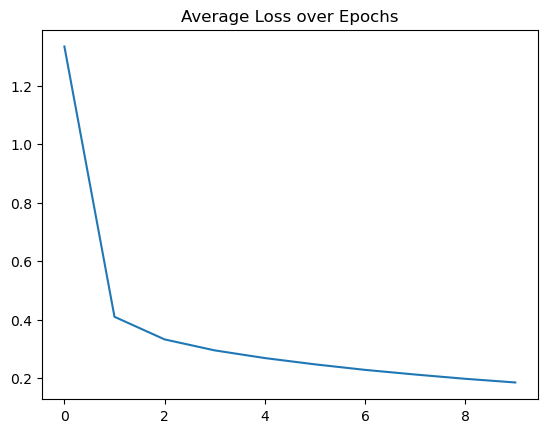

In [81]:
# Plot loss over time with title and axis labels
sns.lineplot(x=range(len(avg_losses)), y=avg_losses.cpu()).set_title(
    "Average Loss over Epochs"
)

In [83]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 94.34%
